In [61]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from zipfile import ZipFile
import urllib.request
import requests
import os
import numpy as np
import pandas as pd

# Data Sourcing #

We want to retrieve the most recent Labour Force Survey Public Use Microdata File (PUMF) from the Statscan website and rename + unzip it

In [79]:
%%script echo skipping    # comment out if data must be retrieved
 
url='https://www150.statcan.gc.ca/n1/pub/71m0001x/2021001/'

file_name = '2023' + '-' + '10' + '-CSV' + '.zip'

urllib.request.urlretrieve(url+file_name, file_name)


with ZipFile(file_name, 'r') as zip_ref:
    zip_ref.extractall()


os.rename('pub'+'1023'+'.csv', 'raw_lfs_data.csv')    

Couldn't find program: 'echo'


In [63]:
raw_data = pd.read_csv('raw_lfs_data.csv')
raw_data.head()

,REC_NUM,SURVYEAR,SURVMNTH,LFSSTAT,PROV,CMA,AGE_12,AGE_6,SEX,MARSTAT,...,LKATADS,LKANSADS,LKOTHERN,PRIORACT,YNOLOOK,TLOLOOK,SCHOOLN,EFAMTYPE,AGYOWNK,FINALWT
0,1,2023,9,4,48,7,10,NaN,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5,NaN,537
1,2,2023,9,1,13,0,10,NaN,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2,NaN,106
2,3,2023,9,4,24,0,12,NaN,2,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,NaN,164
3,4,2023,9,1,47,0,7,NaN,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,18,NaN,143
4,5,2023,9,1,46,6,9,NaN,1,6,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1,NaN,218


It can be seen that the values for the categories are encoded according to the LFS_PUMF_EPA_FGMD_codebook.csv file. 

# Data Cleaning #


### Decoding ### 
The first step is to decode the variables so that their meaning can be interpreted. Using the codebook.csv file we will create a decoding dictionary using the field indicators (column 1), their respective variable values (column 4), and the corresponding English labels (column 5)

In [64]:
code_list=pd.read_csv('LFS_PUMF_EPA_FGMD_codebook.csv', encoding='latin1').to_numpy()

code_dict = {}


# parses the codebook to generate a decoding dictionary based on the variables, variable values, and variable labels.
# ex:
# variable = prov
# variable_val = 13
# variable_label = New Brunswick

# result is a dictionary of dictionaries:    { variable: {   {variable_val: variable_label} , .. } , .. } 


# before starting, we may want to keep a numerical version of the AGE_12 column for modelling
age_12_num = raw_data['AGE_12'].copy()


for i in range(len(code_list)) :

    field_num = code_list[i][0]

    # if field_num (the first column) takes a numerical value then a new variable is detected and added to the dictionary. If Nan then continues to parse the values the previous variables takes on
    if (not(np.isnan(field_num))): 

        variable = code_list[i][3].upper().strip()

        code_dict[variable] = {}

    elif (np.isnan(field_num)):

        try: 
            variable_val = int(code_list[i][3])
        except:
            variable_val = code_list[i][3]

        variable_label = code_list[i][4]
        code_dict[variable][variable_val] = variable_label


# decode labels
for variable in raw_data.columns:

    for variable_val in code_dict[variable]:

        if (type(variable_val)==int):

            raw_data.loc[raw_data[variable] == variable_val,variable] = code_dict[variable][variable_val]




# add back in the numerical AGE_12 values 
raw_data = raw_data.assign(AGE_12_NUM=age_12_num.values)
raw_data.rename(columns={'AGE_12': 'AGE_12_CAT'},inplace=True)

raw_data.head()

,REC_NUM,SURVYEAR,SURVMNTH,LFSSTAT,PROV,CMA,AGE_12_CAT,AGE_6,SEX,MARSTAT,...,LKANSADS,LKOTHERN,PRIORACT,YNOLOOK,TLOLOOK,SCHOOLN,EFAMTYPE,AGYOWNK,FINALWT,AGE_12_NUM
0,1,2023,September,Not in labour force,Alberta,Calgary,60 to 64 years,NaN,Female,Married,...,NaN,NaN,NaN,NaN,NaN,Non-student,"Single-earner couple, male employed, no childr...",NaN,537,10
1,2,2023,September,"Employed, at work",New Brunswick,Other CMA or non-CMA,60 to 64 years,NaN,Male,Married,...,NaN,NaN,NaN,NaN,NaN,Non-student,"Dual-earner couple, no children or none under 25",NaN,106,10
2,3,2023,September,Not in labour force,Quebec,Other CMA or non-CMA,70 and over,NaN,Female,Living in common-law,...,NaN,NaN,NaN,NaN,NaN,NaN,"Non-earner couple, no children or none under 25",NaN,164,12
3,4,2023,September,"Employed, at work",Saskatchewan,Other CMA or non-CMA,45 to 49 years,NaN,Male,Married,...,NaN,NaN,NaN,NaN,NaN,Non-student,Other families,NaN,143,7
4,5,2023,September,"Employed, at work",Manitoba,Winnipeg,55 to 59 years,NaN,Male,"Single, never married",...,NaN,NaN,NaN,NaN,NaN,Non-student,Person not in an economic family,NaN,218,9


In [4]:
# entries
raw_data.shape[0]

108982

### Removing Irrelevant Entries ###

We can see that there are many columns with NaN columns pertaining to whether the individual is currently active in the labour force or not. 

Since we are interested only in individuals having an hourly income, we will eliminate any entries indicating unemployment (dropping any declaration of unemployment + keeping only those who having no response in columns referncing unemployment).


In [5]:
# all columns
raw_data.columns

Index(['REC_NUM', 'SURVYEAR', 'SURVMNTH', 'LFSSTAT', 'PROV', 'CMA',
       'AGE_12_CAT', 'AGE_6', 'SEX', 'MARSTAT', 'EDUC', 'MJH', 'EVERWORK',
       'FTPTLAST', 'COWMAIN', 'IMMIG', 'NAICS_21', 'NOC_10', 'NOC_43',
       'YABSENT', 'WKSAWAY', 'PAYAWAY', 'UHRSMAIN', 'AHRSMAIN', 'FTPTMAIN',
       'UTOTHRS', 'ATOTHRS', 'HRSAWAY', 'YAWAY', 'PAIDOT', 'UNPAIDOT',
       'XTRAHRS', 'WHYPT', 'TENURE', 'PREVTEN', 'HRLYEARN', 'UNION',
       'PERMTEMP', 'ESTSIZE', 'FIRMSIZE', 'DURUNEMP', 'FLOWUNEM', 'UNEMFTPT',
       'WHYLEFTO', 'WHYLEFTN', 'DURJLESS', 'AVAILABL', 'LKPUBAG', 'LKEMPLOY',
       'LKRELS', 'LKATADS', 'LKANSADS', 'LKOTHERN', 'PRIORACT', 'YNOLOOK',
       'TLOLOOK', 'SCHOOLN', 'EFAMTYPE', 'AGYOWNK', 'FINALWT', 'AGE_12_NUM'],
      dtype='object')

In [65]:
df = raw_data.copy()

# drop entries containing no income data
df =df.dropna(subset=['HRLYEARN'])

# drop if not in active labour force
df=df.drop(df[df.LFSSTAT != 'Employed, at work'].index)

# columns associated with unemployment
unemployed_cols= ['DURUNEMP','FLOWUNEM','UNEMFTPT',
                    'WHYLEFTO','WHYLEFTN','DURJLESS',
                    'AVAILABL','LKEMPLOY','LKRELS',
                    'LKATADS','LKANSADS','LKOTHERN',
                    'PRIORACT','YNOLOOK','TLOLOOK',
                    'LKPUBAG','EVERWORK','PREVTEN','FTPTLAST']

# drop any rows with unemploymnent indicator
df = df.drop(df.dropna(subset=unemployed_cols).index)

# drop the respective unemployment columns
df = df.drop('LFSSTAT', axis=1)
df = df.drop(unemployed_cols,axis=1)

df.shape[0]

51684

There are also variables which, though informative for labour force statistics, will not be considered in current analysis


In [66]:
# drop unnecessary or redundant columns
unnecessary_cols = ['REC_NUM','SURVYEAR','SURVMNTH',
                    'AGE_6','FINALWT']

df = df.drop(unnecessary_cols,axis=1)

df.head()

,PROV,CMA,AGE_12_CAT,SEX,MARSTAT,EDUC,MJH,COWMAIN,IMMIG,NAICS_21,...,TENURE,HRLYEARN,UNION,PERMTEMP,ESTSIZE,FIRMSIZE,SCHOOLN,EFAMTYPE,AGYOWNK,AGE_12_NUM
7,Prince Edward Island,Other CMA or non-CMA,40 to 44 years,Male,Married,High school graduate,"Single jobholder, including job changers","Self-employed incorporated, with paid help",Non-immigrant,Retail trade,...,240.0,4418.0,Non-unionized,Permanent,More than 500 employees,More than 500 employees,Non-student,"Dual-earner couple, youngest child 0 to 17",Youngest child 13 to 17 years,6
17,Quebec,Other CMA or non-CMA,50 to 54 years,Male,"Single, never married",Postsecondary certificate or diploma,"Single jobholder, including job changers",Private sector employees,Non-immigrant,Manufacturing - durable goods,...,240.0,2575.0,Non-unionized,Permanent,20 to 99 employees,20 to 99 employees,Non-student,Person not in an economic family,NaN,8
18,Ontario,Other CMA or non-CMA,35 to 39 years,Female,Married,Postsecondary certificate or diploma,"Single jobholder, including job changers",Private sector employees,Non-immigrant,Accommodation and food services,...,55.0,1540.0,Non-unionized,Permanent,20 to 99 employees,100 to 500 employees,Non-student,"Dual-earner couple, youngest child 0 to 17",Youngest child 6 to 12 years,5
21,Quebec,Montréal,35 to 39 years,Male,"Single, never married",High school graduate,"Single jobholder, including job changers",Private sector employees,Non-immigrant,"Information, culture and recreation",...,67.0,2350.0,Union member,Permanent,20 to 99 employees,More than 500 employees,Non-student,Person not in an economic family,NaN,5
24,Ontario,OttawaGatineau (Ontario part),35 to 39 years,Female,Living in common-law,Postsecondary certificate or diploma,"Single jobholder, including job changers",Public sector employees,Non-immigrant,Educational services,...,193.0,2692.0,Union member,Permanent,20 to 99 employees,More than 500 employees,Non-student,"Dual-earner couple, youngest child 0 to 17",Youngest child less than 6 years,5


### Minimum Wage Consideration ###

In [67]:
# convert the hourly earnings to dollars 
# make sure this is only run once otherwise there will be some very low wages!
df.HRLYEARN = df.HRLYEARN/100

# minimum wages across Provinces (NW Territories, Nunavut, Yukon not included)
min_wage = {
    'Alberta' : 15.00,
    'British Columbia': 16.75,
    'Manitoba': 15.30,
    'New Brunswick': 14.75,
    'Newfoundland and Labrador': 15.00,
    'Nova Scotia': 15.00,
    'Ontario': 16.55,
    'Prince Edward Island': 15.00,
    'Quebec': 15.25,
    'Saskatchewan': 14.00
}


wages = df[['PROV','HRLYEARN']].values.tolist()

valid_wage = pd.Series([wage[1] > min_wage[wage[0]] for wage in wages])

df = df[valid_wage.values]

df.shape[0]

47598

# Data Exploration #

<Axes: xlabel='HRLYEARN', ylabel='Count'>

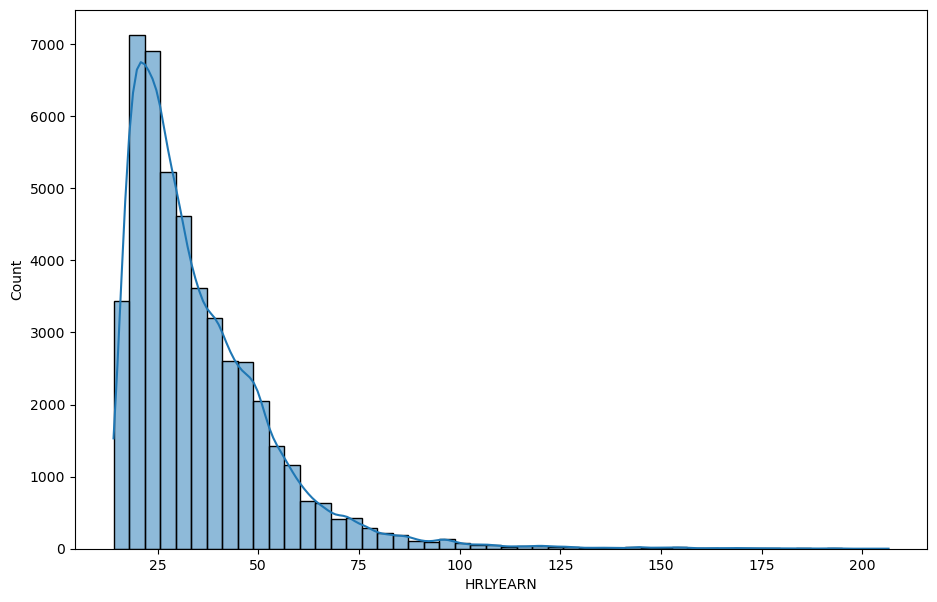

In [68]:
import seaborn as sns

from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11,7

sns.histplot(data=df, x="HRLYEARN",bins=50,kde=True)

<Axes: xlabel='HRLYEARN', ylabel='AGE_12_CAT'>

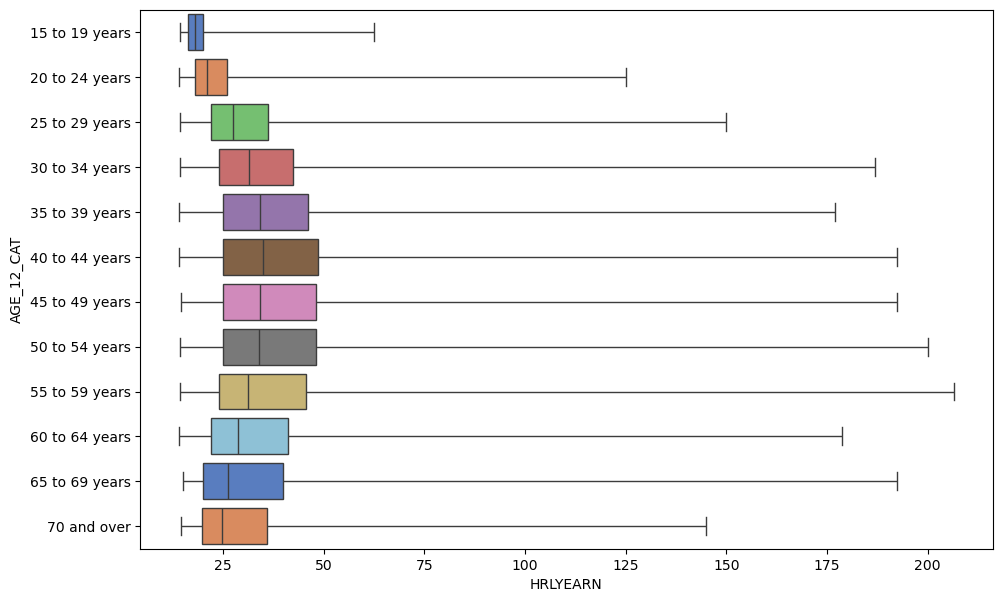

In [75]:
sns.boxplot(x=df["HRLYEARN"], y=df["AGE_12_CAT"], whis=(0, 100),orient='h',palette = "muted", order=list(code_dict['AGE_12'].values()))

<Axes: xlabel='HRLYEARN', ylabel='EDUC'>

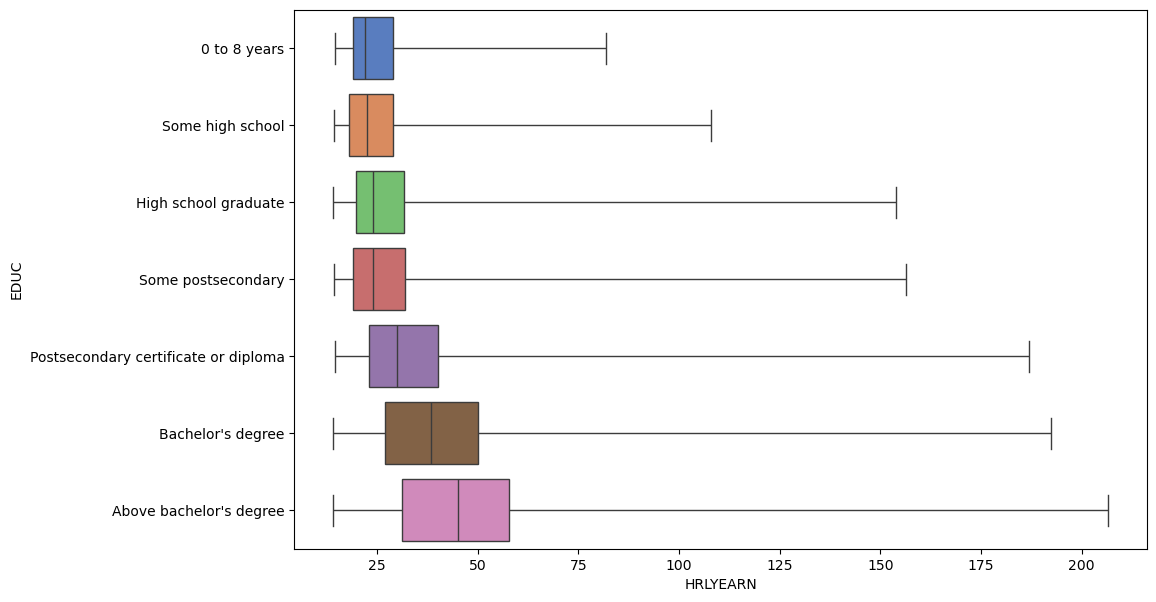

In [77]:
sns.boxplot(x=df["HRLYEARN"], y=df['EDUC'], whis=(0, 100),orient='h',palette = "muted", order=list(code_dict['EDUC'].values()))

<Axes: >

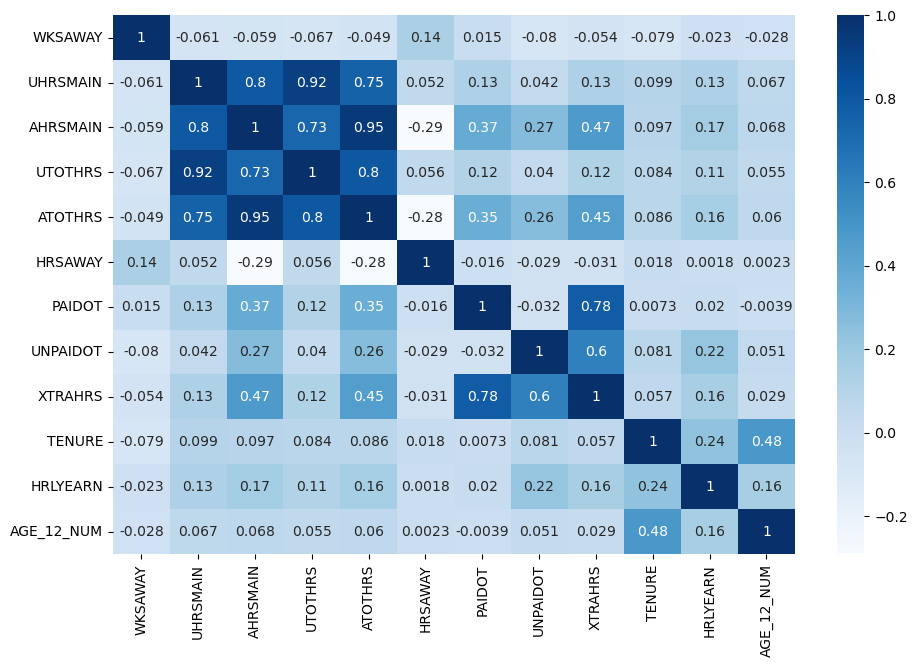

In [78]:
sns.heatmap(df[corr_features].corr(numeric_only=True), cmap="Blues", annot=True)

Though linear correlations may not be overly helpful for feature selection, it is still informative. We can see a high correlation between features relating to hours worked (UHRSMAIN, AHRSMAIN, UTOTHRS, ATOTHRS) and likely would not like to include all of factors in order to avoid colinearity. 

We can also see that HRLYEARN does not appear to have any strong correlations, suggesting a linear estimator might be insufficient in capturing the relationship between the target (HRLYEARN) and other variables.

# Model Selection #




In [55]:
# features of interest for modelling
features=['AGE_12_NUM','FTPTMAIN','SEX','EDUC',
            'NOC_43','NAICS_21','HRLYEARN','TENURE',
            'UHRSMAIN','PROV']

df=df[features]

numeric_features = ['TENURE','UHRSMAIN','AGE_12_NUM']
cat_features = list(set(df.columns)-set(numeric_features))
cat_features.remove('HRLYEARN')


In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, QuantileRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.compose import ColumnTransformer


In [17]:
X=df.drop('HRLYEARN', axis=1)
y=df[['HRLYEARN']]

In [60]:
ct = ColumnTransformer(
    [('scale', MinMaxScaler(), numeric_features),
     ('OHE', OneHotEncoder(), cat_features)])

pipe = Pipeline([('preprocessor', ct), ('estimator', LinearRegression())])


grid_params = [
    {
    'estimator' : [Ridge()],
    'estimator__alpha' : [0.1, 0.5]
    },
    {
    'estimator' : [GradientBoostingRegressor()],
    'estimator__loss' : ['squared_error', 'absolute_error'],
    'estimator__n_estimators' : [50,100,200],
    'estimator__max_depth' : [5, 10]
    }
]

scoring = {'MAE':'neg_mean_absolute_error','RMSE':'neg_root_mean_squared_error'}


grid = GridSearchCV(pipe, grid_params, scoring = scoring, refit='MAE') 

grid.fit(X,y.values.ravel())

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('scale',
                                                                         MinMaxScaler(),
                                                                         ['TENURE',
                                                                          'UHRSMAIN',
                                                                          'AGE_12_NUM']),
                                                                        ('OHE',
                                                                         OneHotEncoder(),
                                                                         ['EDUC',
                                                                          'PROV',
                                                                          'SEX',
                                                                          'FTPTMAIN',
                                                                          'NAICS_21',
                                                                          'NOC_43'])])),
                                       ('estimator', LinearRegression())]),
             param_grid=[{'estimator': [Ridge()],
                          'estimator__alpha': [0.1, 0.5]},
                         {'estimator': [GradientBoostingRegressor(loss='absolute_error',
                                                                  max_depth=10,
                                                                  n_estimators=200)],
                          'estimator__loss': ['squared_error',
                                              'absolute_error'],
                          'estimator__max_depth': [5, 10],
                          'estimator__n_estimators': [50, 100, 200]}],
             refit='MAE',
             scoring={'MAE': 'neg_mean_absolute_error',
                      'RMSE': 'neg_root_mean_squared_error'})

In [59]:
results = pd.DataFrame(grid.cv_results_)

results.sort_values('rank_test_MAE')[['params','mean_test_MAE','mean_test_RMSE']]

,params,mean_test_MAE,mean_test_RMSE
5,{'estimator': GradientBoostingRegressor(loss='...,-7.810069,-13.165019
3,{'estimator': GradientBoostingRegressor(loss='...,-8.032147,-12.626654
1,"{'estimator': Ridge(), 'estimator__alpha': 0.5}",-8.495774,-13.075339
0,"{'estimator': Ridge(), 'estimator__alpha': 0.1}",-8.495783,-13.075389
4,{'estimator': GradientBoostingRegressor(loss='...,-8.522120,-14.192436
2,{'estimator': GradientBoostingRegressor(loss='...,-8.709366,-13.198564


In [167]:
feat_importance = grid.best_estimator_.named_steps.estimator.feature_importances_.tolist()
labels = grid.best_estimator_.named_steps.preprocessor.get_feature_names_out().tolist()

base_features = cat_features + numeric_features
base_importance_agg = [0]*len(base_features)

for feature in base_features:
        
    for sub_category in labels:
            
        if feature in sub_category:
                
            base_importance_agg[base_features.index(feature)] = base_importance_agg[base_features.index(feature)] + feat_importance[labels.index(sub_category)]




feature = labels + base_features
importance = feat_importance + base_importance_agg

final = list(zip(feature,importance))


final_importances = sorted(final,key=lambda x:x[1],reverse=True)

imp_df = pd.DataFrame(final_importances)
base_imp = imp_df[imp_df.iloc[:, 0].isin(base_features)].to_numpy()

<Axes: >

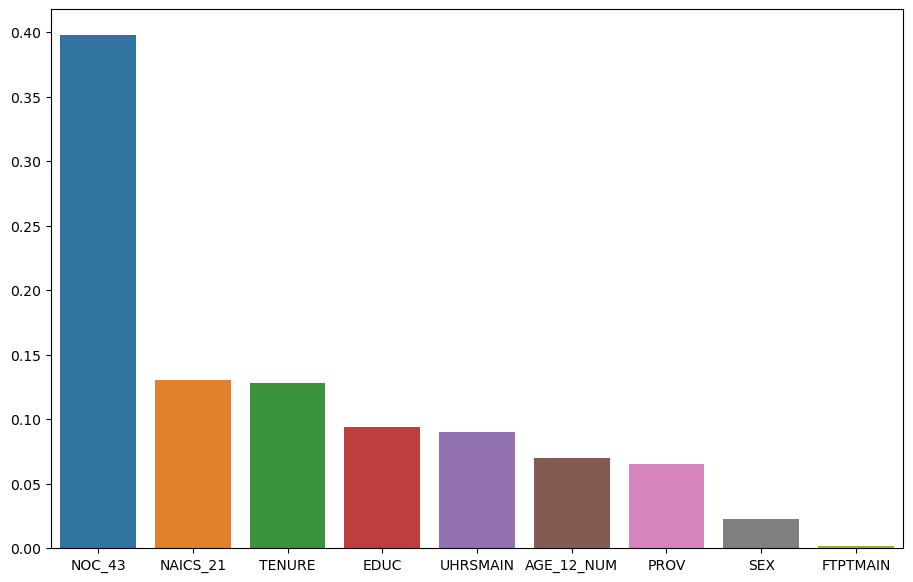

In [190]:
sns.barplot(x=base_imp[::,0],y=base_imp[::,1])

We can see that by far the most important feature based on the model with the highest prediction accuracy is one's National Occupation Classification (NOC_43).